# Imports
Import in the various packages that are used in the code below: 

In [1]:
import PyPDF2 #Reads PDF Files
import sys #System functions 
import collections #Collections
from collections import Counter
import urllib2 #open web URLs *newer version
from StringIO import StringIO #Handles some exceptions for downloading files from URLs
from django.utils.encoding import smart_str, smart_unicode #another method for encoding/decoding ASCII/UTF
import datetime #datetime.now() used to track start/finish of code to check processing time
import pandas as pd #pandas data-frames(tables)
import csv as csv #import/export CSV files
from __future__ import print_function #improves printing out PANDAS for testing their content
import hashlib #create hash of the binary of each file to match files quickly 
import os #allows for an easy pull of the file size from local machine
import json #JSON objects to store dictionaries to disk when memory becomes a challenge
from bs4 import BeautifulSoup #Web Scraping
import urllib #open web URLs
import re #regular expressions
from sklearn.feature_extraction.text import TfidfVectorizer #TFIDF Document Comparison
from sklearn.metrics.pairwise import cosine_similarity #Cosine Similarity
from sklearn.metrics.pairwise import cosine_distances #Cosine Distance
from nltk.stem.lancaster import LancasterStemmer #Reduce Words back to their stems
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import MDS #multidimensional scaling
import nltk
import string
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
import xlsxwriter
import numpy

# Tools

In [2]:
#convert unicode to standard encoding
def convertU(data):
    if isinstance(data, basestring):
        return smart_str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convertU, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convertU, data))
    else:
        return data

#Converts the typical output for a PyPDF2 Metadata Date into a useable format. 
def convertPyPDFDate(origDate):
    if len(origDate) == 23:
        year = origDate[2:6]
        mon = origDate[6:8]
        day = origDate[8:10]
        return (year+"-"+mon+"-"+day)
    return origDate

#######################################
### Spell Checker from Peter Norvig ###
#######################################
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

# Create Directory of original .PDF File URLs

In [5]:
#Creates Tab-Separated File (there are commas in the content) of the metadata for reference
def recreateTsvFile():
    urldf = pd.read_csv("PDFs.csv")  #Import List of PDF Files from CSV
    urldf["URL"][:10] #first 10 rows of column "URL"
    urldf["URL"].value_counts() #visual check for duplicates
    urldf["UID"] = ""  
    urldf["Download"] = "" 
    urldf["CreatedDate"] = ""
    urldf["ModDate"] = ""
    urldf["Creator"] = ""
    urldf["Producer"] = ""
    urldf["Author"] = ""
    urldf["Title"] = ""

    for x in range (0, len(urldf)):
        urldf["UID"][x] = "BSA_"+str(x+101)  #create UID for each PDF FIle

    urldf.to_csv("D:\BSA_PDF_Files\URLs_Updated.txt", sep="\t") #write to new csv file the URL & UID for each

# Download PDF Files

In [6]:
#imput is a preformatted Data frame of the URLs and Unique Identifier (UID) for each file
def downloadPdfAsIs(urldf):

    folder = "D:\BSA_PDF_Files\\"
    
    #hdr tricks the server into thinking the file is being accessd from Mozilla firefox
    #this is neccisary because some servers block the traffic without this header
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

    #loop through all of the URLs in the passed data frame 
    for x in range(0, len(urldf)):
        try: #try was neccisary because ~1% of files failed to download.  this prevents process from crashing
            if pd.isnull(urldf["Download"][x]): #the "Download" field was used to track prior successes and allow me to break the data frame up and process in chunks
                tempURL = str(urldf["URL"][x]) #retrieve URL from the data frame
                tempReq = urllib2.Request(tempURL, headers=hdr) #create request object with urllib2 to open the URL
                try: 
                    tempPage = urllib2.urlopen(tempReq) #attempt to open the URL and capture the page content (PDF file)
                    urldf["Download"][x] = "Success" #if download worked, write "Success" in the "Download" column
                except urllib2.HTTPError, e: 
                    urldf["Download"][x] = e.fp.read() #on error, write the error under the "Download" column
                    continue
                tempPdf = PyPDF2.PdfFileReader(StringIO(tempPage.read())) #create PDF file object from the original URL, using the StringIO function to correct for some errors
            
                if tempPdf.isEncrypted: #check and see if the file is thought to be encrypted
                    try: tempPdf.decrypt('') #if we think its encrypted, attempt to decrypt without a password
                    except: print("Attempted decrpytion failed on line: "+str(x)) #if the decrpytion failed, print to console so the operator realizes and can react
            
                merger = PyPDF2.PdfFileMerger() #create a blank shell of a PDF file that will eventually be merged with the downloaded content
                try: merger.append(tempPdf) #attempt to add the downloaded content to the blank pdf we just created
                except:
                    urldf["Download"][x]="Outfile Error: No Content in File"+str(x) #if the merge of the content fails, write error message to table
                    continue
            
                try: docInfoLen = len(tempPdf.documentInfo) #check and see if the original (URL) PDF file has metadata(documentInfo) that we can detect
                except:
                    urldf["Download"][x]="Encrpytion Error: Couldnt Decrypt Metadata on File"+str(x) #There always is metadata, so if we cant see any, it relates to failing to decrypt the file
                    continue
            
                if docInfoLen>0: #if we have metadata... 
                    try:merger.addMetadata(tempPdf.documentInfo) #try to add the metadata to the PDF shell that we previously added the content to
                    except: urldf["Download"][x]="Metadata error: Metadata not written to file"+str(x) #write error to table if this failed
                    #all of these similar formatted try/excepts are to write the metadata out to the table/data-frame that we have been working from
                    try: urldf["CreatedDate"][x] = convertPyPDFDate(tempPdf.documentInfo["/CreationDate"])
                    except: urldf["CreatedDate"][x] = ""
                
                    try: urldf["ModDate"][x] = convertPyPDFDate(tempPdf.documentInfo["/ModDate"])
                    except: urldf["ModDate"][x] = ""
            
                    try: urldf["Creator"][x] = tempPdf.documentInfo["/Creator"]
                    except: urldf["Creator"][x] = ""
            
                    try: urldf["Producer"][x] = tempPdf.documentInfo["/Producer"]
                    except:urldf["Producer"][x] = ""
            
                    try: urldf["Author"][x] = tempPdf.documentInfo["/Author"]
                    except:urldf["Author"][x] = ""
                
                    try: urldf["Title"][x] = tempPdf.documentInfo["/Title"]
                    except:urldf["Title"][x] = ""
        
        
                outFile= open(folder+urldf["UID"][x]+".pdf", 'wb') #open a new PDF file on the drive to write the merged content and metadata to 
                try: merger.write(outFile) #try to write the file
                except: 
                    outFile.write("Error writing file. Please Manually Download") #if writing fails, annotate it in the table/dataframe
                    urldf["Download"][x]="Outfile Error: No Content in File"+str(x)
                outFile.close()
            else:
                #print(str(x), end=", ")
                continue #for any URL/UID combo where we already wrote in the "Download" field, skip it and move to the next one (helped me run it in batches)
        except:
            urldf.to_csv("D:\BSA_PDF_Files\URLs_Updated.txt",sep="\t",header=True, index=False, encoding='utf-8') #when we have errors, write anything we have in the table/data-frame in memory to disk, and continue working
    urldf.to_csv("D:\BSA_PDF_Files\URLs_Updated.txt",sep="\t",header=True, index=False, encoding='utf-8') #write the table/data-frame out as a tab-sep spreadsheet

############################    
### Run Download Process ###
############################
#recreateTsvFile() #recreate the TSV file/data-frame that we work from, which re-starts the process over again (I used this in the original design/testing of the project)
#urldf = pd.read_csv("D:\BSA_PDF_Files\URLs_Updated.txt", sep="\t") #read the master tsv file into memory that we are working from.  If we dont use the "recreate" function, it resumes from the last time it wrote to disk
#downloadPdfAsIs(urldf) #ready... set... download 37,000+ files!!!

# Create XLSX Workbook to view perfect duplicates

In [7]:
def createHashMatchXLSX():
    with open('D:\BSA_PDF_Files\JSON\hashMatching.json', 'r') as f: #open JSON object of Hash:[UIDs] we just created
         hashMatches = json.load(f)

    workbook = xlsxwriter.Workbook('duplicates.xlsx') #create new XLSX file
    worksheet = workbook.add_worksheet() #create new worksheet in that XLSX file
    x=1 #easy loop value/iterator 
    worksheet.write('A1',"Hash") #add name to first column
    worksheet.write('B1',"UIDs") #add name to second column that identifies all following columns as well
    uniqueUIDs = [] #blank list to start adding the first UID of any unique hash to

    for key, values in hashMatches.iteritems(): #iterate through dictionary on key:value pairs
        worksheet.write(x,0,key) #write the key to the first column of the row as determined by x (0 = row 1 in Excel, so starting from x=1 starts writing data at row 2, with labels in row 1)
        uniqueUIDs.append(values[0]) #add that first (or only) UID to the list of unique files
        for value in values: #iterate through list of UIDs associated with the hash Key
            worksheet.write(x,(values.index(value)+1),value) #write the UIDs in columns, as many columns as needed for the number of UIDs associated with that key
        x+=1    #iterate x so that I always write to the next line
    workbook.close()

# Create JSON Object for Each Downloaded PDF
And Create HASH of each file's binary content to compare for exact duplicates

In [8]:
#create a individaul dictionary for each UID/URL Pairs and write to disk as a JSON object named after the file
#also create a master dictionary with each hashed value as the key, and the file(s) that match that hash as the values (in a list of UID strings)
def createJSON(uid): #process one UID as a time because Dictionarys are immutable and we cannot write to the same name dictionary twice in one iteration
    pdfDict = {} #blank dictionary to add data to
    temp_pdf = PyPDF2.PdfFileReader(file('D:\BSA_PDF_Files\\'+uid+'.pdf',"rb")) #open the PDF file that we have previously saved to disk as a binary object
    
    #below is the process to write each key:value pair into the dictionary for that file
    #2.b. UID:String
    pdfDict.update({'UID':uid})
    
    #2.c. URL:String
    pdfDict.update({'URL':urlref[uid]}) #pulls from the dictionary outside of this function
    
    #2.d. Metadata:Dictionary
    pdfDict.update({'Metadata':temp_pdf.documentInfo})
    
    #2.e. File_Size:long
    pdfDict.update({'File_Size': os.path.getsize('D:\BSA_PDF_Files\\'+uid+'.pdf')}) #uses the OS import to get the file size
    
    #2.f. Hash:String 
    tempHash = hashlib.sha1(open('D:\BSA_PDF_Files\\'+uid+'.pdf','rb').read()).hexdigest() #using the sha1 hashing algorithm, has the binary of the file and write to a temporary string value
    pdfDict.update({'Hash':tempHash}) #add the hash to my file-specific dictionary
    #add has to global dictionary if not already present, else append UID to the hash
    global glbHashes #open global hash dictionary (declared lower in the code, but before this function is called)
    if tempHash in glbHashes:
        glbHashes[tempHash].append(uid) #add new has to global dictionary
    else:
        glbHashes.update({tempHash:[uid]}) #append UID to an existing list of UIDs for that hash value
    
    
    url = urlref[uid].strip().split('/') #break the original URL on the '/' character to determine the domain, folder and file name from the original URL
    #2.g. Domain:String
    pdfDict.update({'Domain':url[2]})
    
    #2.i. Folder: String
    pdfDict.update({'Folder':url[-2]})
    
    #2.j. fileName:String
    pdfDict.update({'File_Name':url[-1]})
    
    with open('D:\BSA_PDF_Files\JSON\\'+uid+'.json','w') as j: #write the tempoary dictionary for the individual PDF file to disk.
        json.dump(pdfDict, j, indent = 4)

#################################
### Run JSON Creation Process ###
#################################        
#Import/create object with UIDs and URLs to use as the starting point for the dictionaries
def createMyJSONobjs():
    urlref = {} #blank dictionary to work from 
    uids = [] #list of UIDs that we need to iterate thought	
    urldf = pd.read_csv("UID_URL_List.txt", sep='\t') #read the file to memeory
    for x in range (0, len(urldf)): 
        urlref.update({urldf["UID"][x]:urldf["URL"][x]}) #create dictionary of UID:URL matching to pull URL and add to JSON for the file
        uids.append(urldf["UID"][x]) #create list of UIDs that we are going to loop over

    glbHashes = {} #blank dictionary for the global hash:uid dictionary
    #Iterate through each and every UID to create a new dictionary for that file:
    for uid in uids:
        try: createJSON(uid) #create exception in case of errors, so the process doesnt fail
        except: print("Failure on UID: "+uid) #less than 0.01% of files had an error in the JSON creation process
    #write the global hashes out as a JSON object as well to store it to disk
    with open ('D:\BSA_PDF_Files\JSON\hashMatching.json','w') as f:
        json.dump(glbHashes, f, indent = 4)

# Pull Textual Content & Page Numbers
Add both to the existing dictionaries for the unique files 

In [3]:
uniqueUIDs = (pd.read_csv('UniqueFileUIDs.csv'))['UID'].tolist() #create list of unique(hash) UIDs to work off of

def convertPDF2String(path):
    content = ""
    # load pdf file
    pdf = PyPDF2.PdfFileReader(file(path,"rb"))
    if pdf.isEncrypted: 
        try: pdf.decrypt('')
        except: print("Attempted decrpytion failed on UID: "+uid)
    # iterate pages
    for i in range(0, pdf.getNumPages()):
        # extract the text from each page
        try: content += pdf.getPage(i).extractText() + " \n"
        except: continue
    # collapse whitespaces
    content = " ".join(content.replace(u"\xa0", " ").split()).encode('utf-8')
    return (content) #.encode('utf-8')

#Append textual content to dictionary for ecah unique PDF file
def contentReadAndAppend(uid):
    try: 
        with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'r') as i:
            uid_dict_check = json.load(i)
            old_content = uid_dict_check["Content"]
    except: 
        old_content = ''
    if len(old_content)==0:
        content = convertPDF2String('D:\BSA_PDF_Files\\'+uid+'.pdf')
        with open('D:\BSA_PDF_Files\JSON\\'+uid+'.json', 'r') as j: #open JSON for the file in question
            uid_dict = json.load(j)
        uid_dict.update({"Content":content})
        with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'w') as k:
            json.dump(uid_dict,k,indent=4)

#for uid in uniqueUIDs:
#    try:contentReadAndAppend(uid)
#    except:print("Error on UID: "+uid)

def addPageNumbers(uid):
    try:
        with open ('D:\BSA_PDF_Files\JSON2\\'+uid+'.json','r') as j:
            uid_dict_check = json.load(i)
            old_pgn = uid_dict_check["Pages"]
    except:
        old_pgn = 0
    if old_pgn==0:
        tempPdf = PyPDF2.PdfFileReader(file('D:\BSA_PDF_Files\\'+uid+'.pdf','rb'))
        if tempPdf.isEncrypted: 
                    try: tempPdf.decrypt('')
                    except: print("Attempted decrpytion failed on uid: "+uid)
        pageNumbers = tempPdf.getNumPages()
        #print (pageNumbers)
        with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'r') as k:
            uid_dict = json.load(k)
        uid_dict.update({"Pages":pageNumbers})
        with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'w') as l:
            json.dump(uid_dict,l,indent=4)
            
#for uid in uniqueUIDs:
#    try:addPageNumbers(uid)
#    except:print("Error on UID: "+uid)

# Scrape Website for "Language of Scouting"
Will be used to tag documents


In [87]:
r = urllib.urlopen('http://www.scouting.org/scoutsource/Media/LOS/All.aspx').read()
soup = BeautifulSoup(r)
#print type(soup)
#print soup.prettify()[0:100000]

#from IPython.display import HTML
#HTML('<iframe src=http://www.scouting.org/scoutsource/Media/LOS/All.aspx width=1000 height=500></iframe>')

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

#Find from <strong> </strong> tags
tds = soup.find_all("td", {"valign": "top"})

BSA_Words_Long = []
BSA_Alternating_Words = []
x=0

for td in tds:
    try:
        word= td.find_all("strong")
        if len(word)>0:
            BSA_Words_Long.append(cleanhtml(str(word[0])[8:-9].decode('utf-8')))
            if x%2 == 0:
                BSA_Alternating_Words.append(cleanhtml(str(word[0])[8:-9].decode('utf-8')))
                print(cleanhtml(str(word[0])[8:-9].decode('utf-8')))
        x+=1
    except:
        continue

with open ('BSA_Dictionary2.txt','w') as e:
    for item in BSA_Words_Long:
        try:e.write("%s\n" % item).decode('utf-8')
        except: continue

with open ('BSA_Dictionary1.txt','w') as e:
    for item in BSA_Alternating_Words:
        try:e.write("%s\n" % item).decode('utf-8')
        except: continue

C:\Users\ajwil\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\ajwil\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


# Initial Content Analysis
        1. Identify document language (English or Spanish)
        2. Identify document tags from BSA Language of Scouting
        3. Append tags and language to JSON and PDF File

In [60]:
eng_stopwords = convertU(nltk.corpus.stopwords.words('english'))
span_stopwords = convertU(nltk.corpus.stopwords.words('spanish'))
p = string.punctuation
d = string.digits
table_p = string.maketrans(p, len(p) * " ")
table_d = string.maketrans(d, len(d) * " ")

bsa_words = []

with open ('BSA_Dictionary_Strings_Bilingual.txt','r') as d:
    temp = convertU(d.read().lower()).split('\n')
for word in temp: #make sure I remove duplicates and stopwords
    if word not in eng_stopwords and word not in span_stopwords and word not in bsa_words:
        bsa_words.append(word)

bsa_english_words = []
with open ('BSA_Dictionary_English_Strings.txt','r') as e:
    temp_english_words = convertU(e.read().lower()).split('\n')
for word in temp_english_words: #remove duplicates, stopwords, and erroneous words
    if word not in eng_stopwords and word not in bsa_english_words and word in bsa_words:
        bsa_english_words.append(word.lower())
        
bsa_spanish_words = []
for word in bsa_words: #remove duplicates and stopwords
    if word not in bsa_english_words and word not in bsa_spanish_words:
        bsa_spanish_words.append(word.lower())
#print(bsa_spanish_words)
#print('*'*75)
#print(bsa_english_words)

uniqueUIDs = (pd.read_csv('UniqueFileUIDs.csv'))['UID'].tolist() #create list of unique(hash) UIDs to work off of

def isSpanish(text):
    text_words = text.strip().split()
    total_words = long(len(text_words))
    spanish_count = 0.0
    for word in text_words:
        if word in span_stopwords:
            spanish_count +=1.0
    if spanish_count/total_words >0.225:
        return True
    return False

def bsaTags(text, is_spanish=False):
    tags = []
    tag_counts = []

    if is_spanish==False: 
        for word in bsa_english_words:
            if word in text and word not in tags:
                tags.append(word)
                tag_counts.append(1)
            elif word in text and word in tags:
                tag_counts[tags.index(word)]+=1

    elif is_spanish==True:
        for word in bsa_spanish_words:
            if word in text and word not in tags:
                tags.append(word)
                tag_counts.append(1)
            elif word in text and word in tags:
                tag_counts[tags.index(word)]+=1
    print(tag_counts)
    print(tags)


def nonBSAtags(text, is_spanish=False):
    ls = LancasterStemmer()
    wnl = WordNetLemmatizer()
    word_counter = {}
    text = convertU(text).translate(table_d).translate(table_p)
    words = text.lower().split()
    stemmed_words=[]
    for word in words:
        try: 
            stemmed_words.append(ls.stem(convertU(word)))
            stemmed_words.append(wnl.lemmatize(convertU(word)))
        except: continue
    
    for word2 in stemmed_words:
        if word2 in word_counter and word2 not in eng_stopwords and word2 not in bsa_words:
            word_counter[word2] += 1
        elif word2 not in word_counter and word2 not in eng_stopwords and word2 not in bsa_words:
            word_counter[word2] = 1
    #popular_words = sorted(word_counter, key = word_counter.get, reverse = True)   
    print(sorted(word_counter, key = word_counter.get, reverse = True)[:7]) 
    
    
    
for uid in uniqueUIDs[:5]:
    with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'r') as g:
        current_document = json.load(g)
    print(uid)
    bsaTags(convertU(current_document['Content'].lower()))
    nonBSAtags(convertU(current_document['Content'].lower()))
    print('*'*75)
       
    
#for uid in uniqueUIDs:
#    with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'r') as f:
#        current_document = json.load(f)
#    if len(current_document['Content'])>0:
#        if isSpanish(current_document['Content'].lower()):
#            current_document.update({'Language':'Spanish'})
#            print(uid+" is a spanish document")
#        else:
#            current_document.update({'Language':'English'})
            #print(uid+" is an english document")
    #else: print(uid+" is a non-text document")

BSA_10976
[1, 1, 1, 1, 1, 1, 1]
['bear', 'board', 'crew', 'pack', 'trading post', 'uniform', 'unit']
['pair', 'per', 'northern', 'tier', 'ar', 'canoe', 'kit']
***************************************************************************
BSA_7676
[1, 1, 1, 1]
['badge', 'beascout', 'beascout.org', 'scout']
['earn', 'success', 'journey', 'start', 'part', 'lot', 'learn']
***************************************************************************
BSA_945
[1, 1, 1, 1, 1, 1, 1, 1, 1]
['committee', 'council', 'different', 'group', 'national office', 'roundtable', 'scout', 'scoutnet', 'ship']
['thi', 'funct', 'us', 'ar', 'user', 'view', '\xc5\x82bbec']
***************************************************************************
BSA_839
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['boy scout', 'boy scouts of america', 'chief', 'council', 'den', 'fos', 'high adventure', 'outdoor program', 'program', 'region', 'scout', 'sea base', 'venture', 'wolf']
['camp', 'high', 'sr', 'adv', 'adventure', 'western'

# Compare Full Text of Documents
    -Identify documents without any Text & Exclude for later processing
    -Investigate Document Similarity using TF-IDF Vectorizer
    -Calculate the pairwise document distance

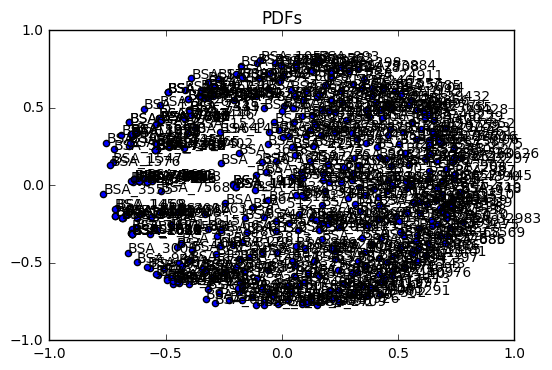

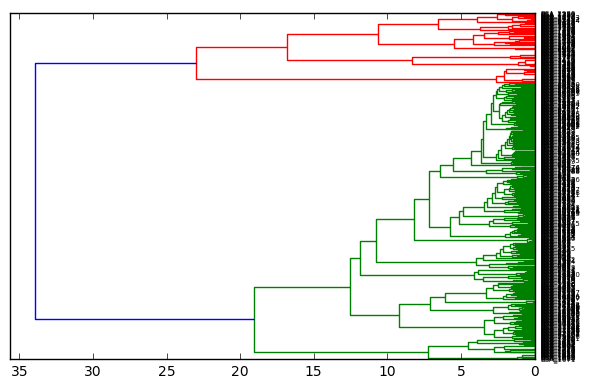

In [39]:
p = string.punctuation
d = string.digits
table_p = string.maketrans(p, len(p) * " ")
table_d = string.maketrans(d, len(d) * " ")

texts = []
text_uids= []
for uid in uniqueUIDs[:500]:
    with open('D:\BSA_PDF_Files\JSON2\\'+uid+'.json', 'r') as i:
            uid_dict= json.load(i)
            if len(uid_dict["Content"])>0:
                texts.append(convertU(uid_dict["Content"]).translate(table_d).translate(table_p))
                text_uids.append(uid)
            else: 
                continue


vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
matrix = vectorizer.fit_transform(texts)
cos_dist = cosine_distances(matrix)
#print(len(text_uids))
#print(cos_dist)
#print(len(cos_dist[0]))
#print(len(cos_dist))
#print(vectorizer.get_feature_names())
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(cos_dist)
#print(pos)
xs, ys = pos[:,0], pos[:,1]
#print(xs)

for x, y, uid in zip(xs, ys, text_uids):
    plt.scatter(x,y)
    plt.text(x, y, uid)
plt.title('PDFs')
plt.show()

linkage_matrix = ward(cos_dist)
dendrogram(linkage_matrix, orientation='left', labels=text_uids)
plt.tight_layout()
plt.show()

#numpy.savetxt('matrix.txt',cos_dist, delimiter=',')
#with open ('Matrix_Labels.txt','w') as l:
#    l.write(",".join(text_uids))
#print(len(text_uids))